In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import zipfile
import matplotlib.pyplot as plt

In [ ]:
dataset=tfds.load("cifar10",split="train")
dataset_test=tfds.load("cifar10",split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZATC4M/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZATC4M/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
def transformation(x):
  x_t=((tf.cast(x["image"],tf.float32)/255.)-0.5)*2.
  return (x_t,x_t)

train_dataset=dataset.map(transformation).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=dataset_test.map(transformation).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def conv_block(count,size,act):
  def func(x):
    c=tf.keras.layers.Conv2D(count,size,padding="same")(x)
    p=tf.keras.layers.MaxPooling2D()(c)
    a=tf.keras.layers.Activation(act)(p)
    return a
  return func

def conv_block_up(count,size,act):
  def func(x):
    c=tf.keras.layers.Conv2D(count,size,padding="same")(x)
    p=tf.keras.layers.UpSampling2D()(c)
    a=tf.keras.layers.Activation(act)(p)
    return a
  return func

In [ ]:
def get_encoder():
  inp=tf.keras.layers.Input((32,32,3))

  b1=conv_block(32,5,"leaky_relu")(inp)#16
  b2=conv_block(32,5,"leaky_relu")(b1)#8
  b3=conv_block(64,4,"leaky_relu")(b2)#4
  b4=conv_block(64,2,"leaky_relu")(b3)#2
  b4=conv_block(128,2,"leaky_relu")(b4)#1

  return tf.keras.models.Model(inp,b4)

def get_decoder():
  inp=tf.keras.layers.Input((1,1,128))

  u1=conv_block_up(128,1,"leaky_relu")(inp)
  u2=conv_block_up(64,2,"leaky_relu")(u1)
  u3=conv_block_up(64,4,"leaky_relu")(u2)
  u4=conv_block_up(32,5,"leaky_relu")(u3)
  u5=conv_block_up(32,5,"leaky_relu")(u4)

  c1=tf.keras.layers.Conv2D(3,1,activation="tanh")(u5)

  return tf.keras.models.Model(inp,c1)

In [ ]:
encoder=get_encoder()
decoder=get_decoder()

In [ ]:
ae=tf.keras.models.Sequential([tf.keras.layers.InputLayer((32,32,3)),
                               encoder,
                               decoder])

ae.compile(loss="mse",optimizer=tf.keras.optimizers.Adam())

In [ ]:
history=ae.fit(train_dataset,validation_data=test_dataset,epochs=100)

Epoch 1/100
1563/1563 [==============================] - 14s 7ms/step - loss: 0.0867 - val_loss: 0.0673
Epoch 2/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0602 - val_loss: 0.0558
Epoch 3/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0532 - val_loss: 0.0507
Epoch 4/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0496 - val_loss: 0.0488
Epoch 5/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0467 - val_loss: 0.0470
Epoch 6/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0449 - val_loss: 0.0449
Epoch 7/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 8/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0425 - val_loss: 0.0416
Epoch 9/100
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0414 - val_loss: 0.0422
Epoch 10/100
1563/1563 [==============================] - 11s 7m

KeyboardInterrupt: 

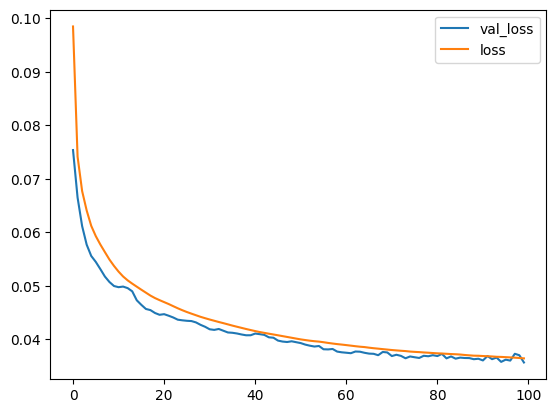

In [ ]:
plt.plot(history.history["val_loss"],label="val_loss")
plt.plot(history.history["loss"],label="loss")
plt.legend()

In [ ]:
encoder.save("simple_encoder_v1")
decoder.save("simple_decoder_v1")

In [ ]:
with zipfile.ZipFile("simple_encoder_v1.zip","w") as zf:
  zf.write("simple_encoder_v1")

with zipfile.ZipFile("simple_decoder_v1.zip","w") as zf:
  zf.write("simple_decoder_v1")

In [ ]:
encoder_tflite=tf.lite.TFLiteConverter.from_keras_model(encoder)
decoder_tflite=tf.lite.TFLiteConverter.from_keras_model(decoder)

In [ ]:
encoder_tflite.optimizations=[tf.lite.Optimize.DEFAULT]
decoder_tflite.optimizations=[tf.lite.Optimize.DEFAULT]

In [ ]:
encoder_tfl_model=encoder_tflite.convert()
decoder_tfl_model=decoder_tflite.convert()

In [ ]:
with open("simple_encoder_quantized_v1.tfl","wb") as f:
  f.write(encoder_tfl_model)

with open("simple_decoder_quantized_v1.tfl","wb") as f:
  f.write(decoder_tfl_model)

In [ ]:
tf.lite.Interpreter("content/simple_encoder_quantized_v1.tfl")

ValueError: Could not open 'content/simple_encoder_quantized_v1.tfl'.